In this challenge, you need to create a machine learning model that will classify SMS messages as either "ham" or "spam". A "ham" message is a normal message sent by a friend. A "spam" message is an advertisement or a message sent by a company.

You should create a function called `predict_message` that takes a message string as an argument and returns a list. The first element in the list should be a number between zero and one that indicates the likeliness of "ham" (0) or "spam" (1). The second element in the list should be the word "ham" or "spam", depending on which is most likely.

For this challenge, you will use the [SMS Spam Collection](http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/) dataset. The dataset has already been grouped into train data and test data.

The first two cells import the libraries and data. The final cell tests your model and function. Add your code in between these cells.

In [1]:
# import libraries
"""
try:
  # %tensorflow_version only exists in Colab.
  !pip install tf-nightly # Already installed
except Exception:
  pass
"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Filter out all TF logs except errors.

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, BatchNormalization, Activation, Dropout, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import ModelCheckpoint
#!pip install tensorflow-datasets # Already installed
import tensorflow_datasets as tfds

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

print(tf.__version__)

E0000 00:00:1721691195.116953  266867 cuda_dnn.cc:8458] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1721691195.122617  266867 cuda_blas.cc:1420] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2.18.0-dev20240718


In [2]:
# get data files
!wget -nc https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
!wget -nc https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv

train_file_path = "train-data.tsv"
valid_file_path = "valid-data.tsv"

File ‘train-data.tsv’ already there; not retrieving.

File ‘valid-data.tsv’ already there; not retrieving.



### Preprocessing

In [3]:
train_dataset = pd.read_csv(train_file_path, sep='\t', header=None, names=['class','message'])
valid_dataset = pd.read_csv(valid_file_path, sep='\t', header=None, names=['class','message'])

In [4]:
train_dataset.tail()

,class,message
4174,ham,just woke up. yeesh its late. but i didn't fal...
4175,ham,what do u reckon as need 2 arrange transport i...
4176,spam,free entry into our £250 weekly competition ju...
4177,spam,-pls stop bootydelious (32/f) is inviting you ...
4178,ham,tell my bad character which u dnt lik in me. ...


In [5]:
train_dataset['class'] = train_dataset['class'].map({'ham':0, 'spam':1})
valid_dataset['class'] = valid_dataset['class'].map({'ham':0, 'spam':1})

In [6]:
train_dataset.tail()

,class,message
4174,0,just woke up. yeesh its late. but i didn't fal...
4175,0,what do u reckon as need 2 arrange transport i...
4176,1,free entry into our £250 weekly competition ju...
4177,1,-pls stop bootydelious (32/f) is inviting you ...
4178,0,tell my bad character which u dnt lik in me. ...


In [7]:
train_labels = np.array(train_dataset.pop('class'))
valid_labels = np.array(valid_dataset.pop('class'))

train_dataset = train_dataset['message']
valid_dataset = valid_dataset['message']

#### Tokenizer

In [8]:
tokenizer = Tokenizer(num_words=7693)
tokenizer.fit_on_texts(train_dataset)

tokenized_train_dataset = tokenizer.texts_to_sequences(train_dataset)
tokenized_valid_dataset = tokenizer.texts_to_sequences(valid_dataset)

In [9]:
df = pd.DataFrame([len(msg) for msg in train_dataset])
df.describe()

,0
count,4179.000000
mean,80.473798
std,60.286348
min,2.000000
25%,35.000000
50%,62.000000
75%,122.000000
max,910.000000


In [10]:
tokenized_train_dataset = np.array([row for row in pad_sequences(tokenized_train_dataset, int(df.max()[0]), padding='post', truncating='post')])
tokenized_valid_dataset = np.array([row for row in pad_sequences(tokenized_valid_dataset, int(df.max()[0]), padding='post', truncating='post')])

#### TF-IDF Vectorizer

In [11]:
vectorizer = TfidfVectorizer()
vectorized_train_dataset = vectorizer.fit_transform(train_dataset)
vectorized_valid_dataset = vectorizer.transform(valid_dataset)

#### Handling Minority Sample

In [12]:
sum(train_labels == 1) / len(train_labels)

0.13400335008375208

##### SMOTE (Synthetic Minority Over-sampling Technique)

In [13]:
smote = SMOTE()
sm_tokenized_train_dataset, sm_train_labels = smote.fit_resample(tokenized_train_dataset, train_labels)

In [14]:
sum(sm_train_labels == 1) / len(sm_train_labels)

0.5

##### Random Under-sampling

In [15]:
rus = RandomUnderSampler(random_state=42)
rus_vectorized_train_dataset, rus_train_labels = rus.fit_resample(vectorized_train_dataset, train_labels)

In [16]:
sum(rus_train_labels == 1) / len(rus_train_labels)

0.5

### Model 1: RNN

In [17]:
# Define RNN model
model1 = Sequential()

model1.add(Embedding(input_dim=1+max([elem for lst in sm_tokenized_train_dataset for elem in lst]), output_dim=64))

model1.add(Bidirectional(LSTM(64)))

model1.add(Dense(64, kernel_initializer=HeNormal()))
model1.add(BatchNormalization())
model1.add(Activation('gelu'))
model1.add(Dropout(0.2))

model1.add(Dense(1, activation="sigmoid"))

# Build the model with a specified input shape
model1.build(input_shape=(None, 910))

# Compile the model
model1.compile(optimizer=Nadam(learning_rate=0.0002), loss="binary_crossentropy", metrics=['acc', 'precision', 'recall', 'auc'])

model1.summary()

I0000 00:00:1721691201.239754  266867 cuda_executor.cc:807] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1721691201.260028  266867 cuda_executor.cc:807] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1721691201.260070  266867 cuda_executor.cc:807] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1721691201.264855  266867 cuda_executor.cc:807] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1721691201.264888  266867 cuda_executor.cc:807] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:172

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 910, 64)        │       492,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 566,977 (2.16 MB)

 Trainable params: 566,849 (2.16 MB)

 Non-trainable params: 128 (512.00 B)

In [18]:
# Model checkpoint callback to save weights during training
checkpoint = ModelCheckpoint(filepath='weights/model1_epoch_{epoch:02d}.weights.h5', save_weights_only=True)

# Train the model
history1 = model1.fit(sm_tokenized_train_dataset, sm_train_labels, epochs=10, batch_size=64, validation_data=(tokenized_valid_dataset, valid_labels), callbacks=[checkpoint])

Epoch 1/10


I0000 00:00:1721691205.703239  266991 cuda_dnn.cc:530] Loaded cuDNN version 8907


114/114 ━━━━━━━━━━━━━━━━━━━━ 27s 193ms/step - acc: 0.7596 - auc: 0.8329 - loss: 0.5129 - precision: 0.7357 - recall: 0.8043 - val_acc: 0.8714 - val_auc: 0.9609 - val_loss: 0.4893 - val_precision: 1.0000 - val_recall: 0.0428
Epoch 2/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 23s 199ms/step - acc: 0.9332 - auc: 0.9784 - loss: 0.2003 - precision: 0.9282 - recall: 0.9373 - val_acc: 0.9576 - val_auc: 0.9796 - val_loss: 0.3612 - val_precision: 1.0000 - val_recall: 0.6845
Epoch 3/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 22s 189ms/step - acc: 0.9660 - auc: 0.9933 - loss: 0.1148 - precision: 0.9788 - recall: 0.9533 - val_acc: 0.9504 - val_auc: 0.9825 - val_loss: 0.1461 - val_precision: 1.0000 - val_recall: 0.6310
Epoch 4/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 20s 175ms/step - acc: 0.9814 - auc: 0.9973 - loss: 0.0735 - precision: 0.9915 - recall: 0.9714 - val_acc: 0.9605 - val_auc: 0.9788 - val_loss: 0.1361 - val_precision: 0.8235 - val_recall: 0.8984
Epoch 5/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 21s 181ms/step - acc: 0.9892 - 

In [19]:
epoch_number1 = int(input("From which epoch do you want to load the model weights?\nEpoch:"))

model1.load_weights(f'weights/model1_epoch_{epoch_number1:02d}.weights.h5')

From which epoch do you want to load the model weights?
Epoch: 5


In [20]:
#loss_m1, accuracy_m1, precision_m1, recall_m1, auc_m1 = model1.evaluate(tokenized_valid_dataset, valid_labels)
y_pred_m1 = model1.predict(tokenized_valid_dataset)
y_pred_binary_m1 = (y_pred_m1 >= 0.5).astype(int)

accuracy_m1 = accuracy_score(valid_labels, y_pred_binary_m1)
precision_m1 = precision_score(valid_labels, y_pred_binary_m1)
recall_m1 = recall_score(valid_labels, y_pred_binary_m1)
f1_m1 = f1_score(valid_labels, y_pred_binary_m1)
auc_m1 = roc_auc_score(valid_labels, y_pred_binary_m1)

print(f"Accuracy: {accuracy_m1}")
print(f"Precision (TP / TP+FP): {precision_m1}")
print(f"Recall (TP / TP+FN): {recall_m1}")
print(f"F1-score: {f1_m1}")
print(f"AUC: {auc_m1}")

44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step
Accuracy: 0.9806034482758621
Precision (TP / TP+FP): 0.9545454545454546
Recall (TP / TP+FN): 0.8983957219251337
F1-score: 0.9256198347107438
AUC: 0.9458783588878781


In [21]:
# function to predict messages based on model
# (should return list containing prediction and label, ex. [0.008318834938108921, 'ham'])
def predict_message1(pred_text):
  tokenized_text = tokenizer.texts_to_sequences([pred_text])
  padded_tokenized_text = np.array([row for row in pad_sequences(tokenized_text, int(df.max()[0]), padding='post', truncating='post')])

  prob = model1.predict(padded_tokenized_text)
  prediction = [prob[0][0], 'ham' if prob[0][0] < 0.5 else 'spam']

  return prediction

pred_text = "how are you doing today?"

prediction = predict_message1(pred_text)
print(prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
[0.00039618692, 'ham']


### Model 2: CNN

In [22]:
# Define CNN model
model2 = Sequential()

model2.add(Embedding(input_dim=1+max([elem for lst in sm_tokenized_train_dataset for elem in lst]), output_dim=64))

model2.add(Conv1D(64, 5))
model2.add(BatchNormalization())
model2.add(Activation('gelu'))
model2.add(Dropout(0.2))

model2.add(GlobalMaxPooling1D())

model2.add(Dense(1, activation='sigmoid'))

# Build the model with a specified input shape
model2.build(input_shape=(None, 910))

# Compile the model
model2.compile(optimizer=Nadam(learning_rate=0.00075), loss="binary_crossentropy", metrics=['acc', 'precision', 'recall', 'auc'])

model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 910, 64)        │       492,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 906, 64)        │        20,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 906, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 906, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 906, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 513,217 (1.96 MB)

 Trainable params: 513,089 (1.96 MB)

 Non-trainable params: 128 (512.00 B)

In [23]:
# Model checkpoint callback to save weights during training
checkpoint = ModelCheckpoint(filepath='weights/model2_epoch_{epoch:02d}.weights.h5', save_weights_only=True)

# Train the model
history2 = model2.fit(sm_tokenized_train_dataset, sm_train_labels, epochs=10, batch_size=64, validation_data=(tokenized_valid_dataset, valid_labels), callbacks=[checkpoint])

Epoch 1/10


I0000 00:00:1721691441.594922  266985 service.cc:148] XLA service 0x7f1f90569af0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1721691441.594973  266985 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6


 16/114 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.5744 - auc: 0.6260 - loss: 1.1072 - precision: 0.5768 - recall: 0.7286

I0000 00:00:1721691443.949794  266985 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


114/114 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - acc: 0.7567 - auc: 0.8304 - loss: 0.5608 - precision: 0.7398 - recall: 0.8140 - val_acc: 0.9619 - val_auc: 0.9813 - val_loss: 0.6468 - val_precision: 0.8221 - val_recall: 0.9144
Epoch 2/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - acc: 0.9877 - auc: 0.9979 - loss: 0.0701 - precision: 0.9923 - recall: 0.9827 - val_acc: 0.9799 - val_auc: 0.9873 - val_loss: 0.5651 - val_precision: 0.9704 - val_recall: 0.8770
Epoch 3/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - acc: 0.9986 - auc: 1.0000 - loss: 0.0246 - precision: 0.9999 - recall: 0.9974 - val_acc: 0.9799 - val_auc: 0.9891 - val_loss: 0.4061 - val_precision: 0.9877 - val_recall: 0.8610
Epoch 4/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - acc: 0.9992 - auc: 1.0000 - loss: 0.0125 - precision: 1.0000 - recall: 0.9983 - val_acc: 0.9806 - val_auc: 0.9899 - val_loss: 0.2059 - val_precision: 0.9878 - val_recall: 0.8663
Epoch 5/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - acc: 0.9999 - auc: 1.000

In [24]:
epoch_number2 = int(input("From which epoch do you want to load the model weights?\nEpoch:"))

model2.load_weights(f'weights/model2_epoch_{epoch_number2:02d}.weights.h5')

From which epoch do you want to load the model weights?
Epoch: 5


In [25]:
#loss_m2, accuracy_m2, precision_m2, recall_m2, auc_m2 = model2.evaluate(tokenized_valid_dataset, valid_labels)
y_pred_m2 = model2.predict(tokenized_valid_dataset)
y_pred_binary_m2 = (y_pred_m2 >= 0.5).astype(int)

accuracy_m2 = accuracy_score(valid_labels, y_pred_binary_m2)
precision_m2 = precision_score(valid_labels, y_pred_binary_m2)
recall_m2 = recall_score(valid_labels, y_pred_binary_m2)
f1_m2 = f1_score(valid_labels, y_pred_binary_m2)
auc_m2 = roc_auc_score(valid_labels, y_pred_binary_m2)

print(f"Accuracy: {accuracy_m2}")
print(f"Precision (TP / TP+FP): {precision_m2}")
print(f"Recall (TP / TP+FN): {recall_m2}")
print(f"F1-score: {f1_m2}")
print(f"AUC: {auc_m2}")

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Accuracy: 0.9834770114942529
Precision (TP / TP+FP): 0.9880952380952381
Recall (TP / TP+FN): 0.8877005347593583
F1-score: 0.9352112676056338
AUC: 0.943020391861007


In [26]:
# function to predict messages based on model
# (should return list containing prediction and label, ex. [0.008318834938108921, 'ham'])
def predict_message2(pred_text):
  tokenized_text = tokenizer.texts_to_sequences([pred_text])
  padded_tokenized_text = np.array([row for row in pad_sequences(tokenized_text, int(df.max()[0]), padding='post', truncating='post')])

  prob = model2.predict(padded_tokenized_text)
  prediction = [prob[0][0], 'ham' if prob[0][0] < 0.5 else 'spam']

  return prediction

pred_text = "how are you doing today?"

prediction = predict_message2(pred_text)
print(prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
[0.011103924, 'ham']


### Model 3: Logistic Regression

In [27]:
# Create a pipeline that applies logistic regression
model3 = Pipeline([
    ('logreg', LogisticRegression())
])

# Train the model
model3.fit(rus_vectorized_train_dataset, rus_train_labels)

Pipeline(steps=[('logreg', LogisticRegression())])

In [28]:
y_pred_m3 = model3.predict(vectorized_valid_dataset)

accuracy_m3 = accuracy_score(valid_labels, y_pred_m3)
precision_m3 = precision_score(valid_labels, y_pred_m3)
recall_m3 = recall_score(valid_labels, y_pred_m3)
f1_m3 = f1_score(valid_labels, y_pred_m3)
auc_m3 = roc_auc_score(valid_labels, y_pred_m3)

print(f"Accuracy: {accuracy_m3}")
print(f"Precision (TP / TP+FP): {precision_m3}")
print(f"Recall (TP / TP+FN): {recall_m3}")
print(f"F1-score: {f1_m3}")
print(f"AUC: {auc_m3}")

Accuracy: 0.9712643678160919
Precision (TP / TP+FP): 0.8620689655172413
Recall (TP / TP+FN): 0.9358288770053476
F1-score: 0.8974358974358975
AUC: 0.956296181241263


In [29]:
# function to predict messages based on model
# (should return list containing prediction and label, ex. [0.008318834938108921, 'ham'])
def predict_message3(message):
    # Transform the input message using the TF-IDF vectorizer
    vectorized_message = vectorizer.transform([message])
    
    # Get the probabilities of the message being "ham" or "spam"
    probability = model3.named_steps['logreg'].predict_proba(vectorized_message)[0]

    prediction = [probability[1], 'ham' if probability[1] < 0.5 else 'spam']
    
    return prediction

pred_text = "how are you doing today?"

prediction = predict_message3(pred_text)
print(prediction)

[0.13193917443190267, 'ham']


### Model 4: Multinomial Naive Bayes

In [30]:
# Create a pipeline that applies multinomial naive bayes
model4 = Pipeline([
    ('nb', MultinomialNB())
])

# Train the model
model4.fit(rus_vectorized_train_dataset, rus_train_labels)

Pipeline(steps=[('nb', MultinomialNB())])

In [31]:
y_pred_m4 = model4.predict(vectorized_valid_dataset)

accuracy_m4 = accuracy_score(valid_labels, y_pred_m4)
precision_m4 = precision_score(valid_labels, y_pred_m4)
recall_m4 = recall_score(valid_labels, y_pred_m4)
f1_m4 = f1_score(valid_labels, y_pred_m4)
auc_m4 = roc_auc_score(valid_labels, y_pred_m4)

print(f"Accuracy: {accuracy_m4}")
print(f"Precision (TP / TP+FP): {precision_m4}")
print(f"Recall (TP / TP+FN): {recall_m4}")
print(f"F1-score: {f1_m4}")
print(f"AUC: {auc_m4}")

Accuracy: 0.9604885057471264
Precision (TP / TP+FP): 0.7844827586206896
Recall (TP / TP+FN): 0.9732620320855615
F1-score: 0.8687350835322196
AUC: 0.9658841280759758


In [32]:
# function to predict messages based on model
# (should return list containing prediction and label, ex. [0.008318834938108921, 'ham'])
def predict_message4(message):
    # Transform the input message using the TF-IDF vectorizer
    vectorized_message = vectorizer.transform([message])
    
    # Get the probabilities of the message being "ham" or "spam"
    probability = model4.named_steps['nb'].predict_proba(vectorized_message)[0]
    
    prediction = [probability[1], 'ham' if probability[1] < 0.5 else 'spam']
    
    return prediction

pred_text = "how are you doing today?"

prediction = predict_message4(pred_text)
print(prediction)

[0.14868867418362103, 'ham']


### Model 5: SVM

In [33]:
# Create a pipeline that applies SVM
model5 = Pipeline([
    ('svm', SVC())
])

# Train the model
model5.fit(rus_vectorized_train_dataset, rus_train_labels)

Pipeline(steps=[('svm', SVC())])

In [34]:
y_pred_m5 = model5.predict(vectorized_valid_dataset)

accuracy_m5 = accuracy_score(valid_labels, y_pred_m5)
precision_m5 = precision_score(valid_labels, y_pred_m5)
recall_m5 = recall_score(valid_labels, y_pred_m5)
f1_m5 = f1_score(valid_labels, y_pred_m5)
auc_m5 = roc_auc_score(valid_labels, y_pred_m5)

print(f"Accuracy: {accuracy_m5}")
print(f"Precision (TP / TP+FP): {precision_m5}")
print(f"Recall (TP / TP+FN): {recall_m5}")
print(f"F1-score: {f1_m5}")
print(f"AUC: {auc_m5}")

Accuracy: 0.9834770114942529
Precision (TP / TP+FP): 0.9408602150537635
Recall (TP / TP+FN): 0.9358288770053476
F1-score: 0.938337801608579
AUC: 0.9633501231499767


In [35]:
# function to predict messages based on model
# (should return list containing prediction and label, ex. [0.008318834938108921, 'ham'])
def predict_message5(message):
    # Transform the input message using the TF-IDF vectorizer
    vectorized_message = vectorizer.transform([message])
    
    # Get the confidence score and convert it to probability-like score using the sigmoid function
    confidence_score = model5.named_steps['svm'].decision_function(vectorized_message)[0]
    probability = 1 / (1 + np.exp(-confidence_score))
    
    prediction = [probability, 'ham' if probability < 0.5 else 'spam']
    
    return prediction

pred_text = "how are you doing today?"

prediction = predict_message5(pred_text)
print(prediction)

[0.26747331333608726, 'ham']


### Model 6: Random Forest

In [36]:
n_estimators_range = range(10, 310, 10)
accuracies = []
precisions = []
recalls = []
f1s = []
aucs = []

# Loop to determine the best value for n_estimators
for n in n_estimators_range:
    model6n = Pipeline([
        ('rf', RandomForestClassifier(n_estimators=n, random_state=35))
    ])

    model6n.fit(rus_vectorized_train_dataset, rus_train_labels)

    y_pred_m6n = model6n.predict(vectorized_valid_dataset)

    accuracies.append(accuracy_score(valid_labels, y_pred_m6n))
    precisions.append(precision_score(valid_labels, y_pred_m6n))
    recalls.append(recall_score(valid_labels, y_pred_m6n))
    f1s.append(f1_score(valid_labels, y_pred_m6n))
    aucs.append(roc_auc_score(valid_labels, y_pred_m6n))

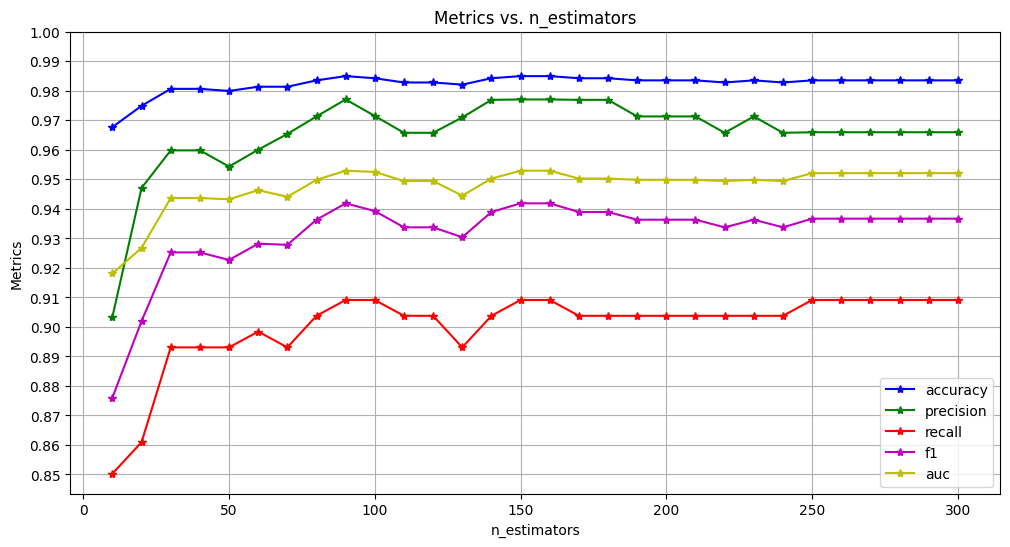

In [37]:
# Plot the results
plt.figure(figsize=(12, 6))

plt.plot(n_estimators_range, accuracies, label='accuracy', color='b', marker='*')
plt.plot(n_estimators_range, precisions, label='precision', color='g', marker='*')
plt.plot(n_estimators_range, recalls, label='recall', color='r', marker='*')
plt.plot(n_estimators_range, f1s, label='f1', color='m', marker='*')
plt.plot(n_estimators_range, aucs, label='auc', color='y', marker='*')

plt.title('Metrics vs. n_estimators')
plt.xlabel('n_estimators')
plt.ylabel('Metrics')

plt.xticks(np.arange(0, 310, 50))
plt.yticks(np.arange(0.85, 1.0, 0.01))

plt.grid(True)
plt.legend()

plt.show()

In [38]:
# Create a pipeline that applies SVM
model6 = Pipeline([
    ('rf', RandomForestClassifier(n_estimators=90, random_state=35))
])

# Train the model
model6.fit(rus_vectorized_train_dataset, rus_train_labels)

Pipeline(steps=[('rf',
                 RandomForestClassifier(n_estimators=90, random_state=35))])

In [39]:
y_pred_m6 = model6.predict(vectorized_valid_dataset)

accuracy_m6 = accuracy_score(valid_labels, y_pred_m6)
precision_m6 = precision_score(valid_labels, y_pred_m6)
recall_m6 = recall_score(valid_labels, y_pred_m6)
f1_m6 = f1_score(valid_labels, y_pred_m6)
auc_m6 = roc_auc_score(valid_labels, y_pred_m6)

print(f"Accuracy: {accuracy_m6}")
print(f"Precision (TP / TP+FP): {precision_m6}")
print(f"Recall (TP / TP+FN): {recall_m6}")
print(f"F1-score: {f1_m6}")
print(f"AUC: {auc_m6}")

Accuracy: 0.9849137931034483
Precision (TP / TP+FP): 0.9770114942528736
Recall (TP / TP+FN): 0.9090909090909091
F1-score: 0.9418282548476454
AUC: 0.9528857035081102


In [40]:
# function to predict messages based on model
# (should return list containing prediction and label, ex. [0.008318834938108921, 'ham'])
def predict_message6(message):
    # Transform the input message using the TF-IDF vectorizer
    vectorized_message = vectorizer.transform([message])
    
    # Get the probabilities of the message being "ham" or "spam"
    probability = model6.named_steps['rf'].predict_proba(vectorized_message)[0]
    
    prediction = [probability[1], 'ham' if probability[1] < 0.5 else 'spam']
    
    return prediction

pred_text = "how are you doing today?"

prediction = predict_message6(pred_text)
print(prediction)

[0.0, 'ham']


### Weighted Soft Voting Ensemble Method

In [41]:
# function to predict messages based on model
# (should return list containing prediction and label, ex. [0.008318834938108921, 'ham'])
def predict_message(message):
    functions = [predict_message1, predict_message2, predict_message3, predict_message4, predict_message5, predict_message6]
    weights = [f1_m1,f1_m2,f1_m3,f1_m4,f1_m5,f1_m6]

    # For each model, get the probability of the message being "spam"
    probabilities = [f(message)[0] for f in functions]

    # Get the weighted average of the probabilities
    probability = np.average(probabilities, weights=weights)
    
    prediction = [probability, 'ham' if probability < 0.5 else 'spam']
    
    return prediction

pred_text = "how are you doing today?"

prediction = predict_message(pred_text)
print(prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
[0.09248121008024211, 'ham']


In [42]:
# Run this cell to test your function and model. Do not modify contents.
def test_predictions():
  test_messages = ["how are you doing today",
                   "sale today! to stop texts call 98912460324",
                   "i dont want to go. can we try it a different day? available sat",
                   "our new mobile video service is live. just install on your phone to start watching.",
                   "you have won £1000 cash! call to claim your prize.",
                   "i'll bring it tomorrow. don't forget the milk.",
                   "wow, is your arm alright. that happened to me one time too"
                  ]

  test_answers = ["ham", "spam", "ham", "spam", "spam", "ham", "ham"]
  passed = True

  for msg, ans in zip(test_messages, test_answers):
    prediction = predict_message(msg)
    if prediction[1] != ans:
      passed = False

  if passed:
    print("You passed the challenge. Great job!")
  else:
    print("You haven't passed yet. Keep trying.")

test_predictions()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
You passed the challenge. Great job!
